In [98]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# load dataset
dataset = pd.read_csv('SimpleEnergyUsage.csv')


In [99]:
dataset.head()

,Date,National Avg Temp (F),NG ($/MSCF),US Crude Price ($/BBL),Electricity ($/kWh),US Petroleum Products (Million Barrels),Electrical Generation (Billion Kilowatthours),U.S. Natural Usage (BCF)
0,1/1/1981,32.4,3.94,28.81,0.053,571.321,413.516410,1890
1,2/1/1981,34.5,3.99,34.30,0.055,475.689,359.719821,1702
2,3/1/1981,37.3,4.06,34.59,0.056,493.111,371.667764,1871
3,4/1/1981,41.7,4.11,33.92,0.056,460.490,345.682684,1808
4,5/1/1981,45.2,4.29,32.73,0.058,475.943,356.277107,1838


In [100]:
#format dates and drop null values

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['year'] = pd.DatetimeIndex(dataset['Date']).year
dataset['month'] = pd.DatetimeIndex(dataset['Date']).month
dataset = dataset.dropna()
dataset.tail()


,Date,National Avg Temp (F),NG ($/MSCF),US Crude Price ($/BBL),Electricity ($/kWh),US Petroleum Products (Million Barrels),Electrical Generation (Billion Kilowatthours),U.S. Natural Usage (BCF),year,month
449,2018-06-01,49.4,16.51,62.80,0.142,621.160,743.661142,2955,2018,6
450,2018-07-01,53.1,17.92,67.00,0.143,639.261,823.648759,3108,2018,7
451,2018-08-01,55.7,18.63,62.64,0.142,660.371,819.962135,3180,2018,8
452,2018-09-01,57.0,17.32,63.55,0.142,598.542,712.675051,3135,2018,9
453,2018-10-01,56.7,12.26,65.18,0.137,643.980,649.800520,3273,2018,10


In [101]:
 # Assign X (data) and y (target)

X = dataset[['year', 'month','National Avg Temp (F)', 'NG ($/MSCF)', 'US Crude Price ($/BBL)', 'Electricity ($/kWh)', 'Electrical Generation (Billion Kilowatthours)','U.S. Natural Usage (BCF)']]
y = dataset['US Petroleum Products (Million Barrels)'].values.reshape(-1,1)

print(X.shape, y.shape)

(454, 8) (454, 1)


In [102]:
# Split the data into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state=42)

In [103]:
#initiate and fit the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

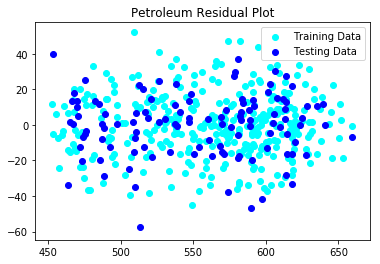

In [104]:
# plot residuals of the predictions
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="cyan", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="blue", label="Testing Data")
plt.legend()
plt.title("Petroleum Residual Plot")
plt.savefig('Petroleum Residual Plot.jpg')
plt.show()


In [105]:
#show model feature coefficients
model.coef_
petrol_coef = pd.concat([pd.DataFrame(X.columns, columns = ['Feature']),pd.DataFrame(np.transpose(model.coef_), columns=['Coef'])], axis = 1)
petrol_intercept = model.intercept_
petrol_coef

,Feature,Coef
0,year,4.943153
1,month,3.663229
2,National Avg Temp (F),-0.770438
3,NG ($/MSCF),3.022959
4,US Crude Price ($/BBL),-0.249099
5,Electricity ($/kWh),-2488.698673
6,Electrical Generation (Billion Kilowatthours),0.251000
7,U.S. Natural Usage (BCF),0.030049


In [106]:
#generate forecast values array and future forecasts array
coefArr=np.array(petrol_coef['Coef'])
newX = X.loc[430:454]
newForecasts = []

for j in range(len(newX)):
    j += 430
    newX_row = np.array(newX.loc[j])
    newfcst = newX_row.dot(coefArr)+petrol_intercept
    newForecasts.append(newfcst)


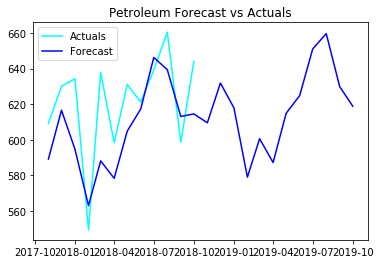

MSE: 305.9690320612286, R2: 0.9012314629976216


In [107]:
#Plot Petroleum Forecast
futuredates = np.arange('2017-11', '2019-11', dtype='datetime64[M]')
dates = dataset['Date'].loc[442:454]

plt.plot(dates,y[442:454], c='cyan', label = "Actuals")
plt.plot(futuredates, newForecasts, c="blue", label="Forecast")
plt.legend()
plt.title("Petroleum Forecast vs Actuals")
plt.savefig('Petroleum Forecast vs Actuals.jpg')
plt.show()


MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

In [108]:
#Create dataframe of predicted versus actual values
petrol_predicted_df = pd.DataFrame(newForecasts,futuredates, columns =['Predicted US Petroleum Products (Million Barrels)'])
petrol_actual_df = pd.DataFrame(y[442:454],dates, columns =['Actual US Petroleum Products (Million Barrels)'])
joineddf = petrol_actual_df.join(petrol_predicted_df, on='Date', how = 'outer')
petrol_df = joineddf.tail(24)
petrol_df

#save as csv
petrol_df.to_csv('petrol.csv')

In [109]:
#Natuarl Gas Forecast
X_ng = dataset[['year', 'month','National Avg Temp (F)', 'NG ($/MSCF)', 'US Crude Price ($/BBL)', 'Electricity ($/kWh)', 'Electrical Generation (Billion Kilowatthours)','US Petroleum Products (Million Barrels)']]
y_ng = dataset['U.S. Natural Usage (BCF)'].values.reshape(-1,1)

Xng_train, Xng_test, yng_train, yng_test = train_test_split(X_ng, y_ng, shuffle = True, random_state=40)

ng_model = LinearRegression()
ng_model.fit(Xng_train, yng_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

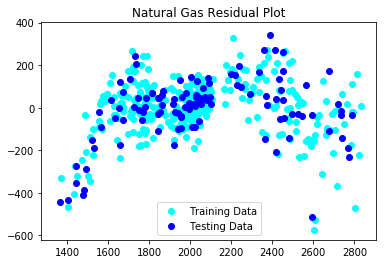

In [110]:
# plot residuals of the predictions
predictions_ng = ng_model.predict(Xng_test)
ng_model.fit(Xng_train, yng_train)
plt.scatter(ng_model.predict(Xng_train), ng_model.predict(Xng_train) - yng_train, c="cyan", label="Training Data")
plt.scatter(ng_model.predict(Xng_test), ng_model.predict(Xng_test) - yng_test, c="blue", label="Testing Data")
plt.legend()
plt.title("Natural Gas Residual Plot")
plt.savefig('Natural Gas Residual Plot.jpg')
plt.show()


In [111]:
#show model feature coefficients
ng_model.coef_
ng_coef = pd.concat([pd.DataFrame(X_ng.columns, columns = ['Feature']),pd.DataFrame(np.transpose(ng_model.coef_), columns=['Coef'])], axis = 1)
ng_intercept = ng_model.intercept_

In [112]:
#generate forecast values array and future forecasts array
ng_coefArr=np.array(ng_coef['Coef'])
newX_ng = X_ng.loc[430:454]
newForecasts_ng = []

for j in range(len(newX_ng)):
    j += 430
    newX_ng_row = np.array(newX_ng.loc[j])
    newfcst_ng = newX_ng_row.dot(ng_coefArr)+ng_intercept
    newForecasts_ng.append(newfcst_ng)

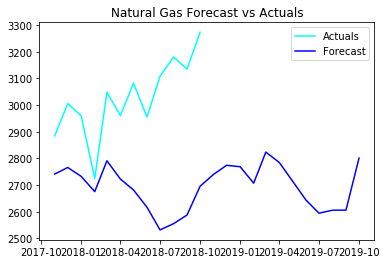

MSE: 22210.451974870193, R2: 0.8192007560262039


In [113]:
#Plot Natural Gas Forecast
plt.plot(dates,y_ng[442:454], c='cyan', label = "Actuals")
plt.plot(futuredates, newForecasts_ng, c="blue", label="Forecast")
plt.legend()
plt.title("Natural Gas Forecast vs Actuals")
plt.savefig('Natural Gas Forecast vs Actuals.jpg')
plt.show()


MSE_ng = mean_squared_error(yng_test, predictions_ng)
r2_ng = ng_model.score(Xng_test, yng_test)

print(f"MSE: {MSE_ng}, R2: {r2_ng}")

In [114]:
#Create dataframe of predicted versus actual values
ng_predicted_df = pd.DataFrame(newForecasts_ng,futuredates, columns =['Predicted U.S. Natural Usage (BCF)'])
ng_actual_df = pd.DataFrame(y_ng[442:454],dates, columns =['Actual U.S. Natural Usage (BCF)'])
ng_joineddf = ng_actual_df.join(ng_predicted_df, on='Date', how = 'outer')
ng_df = ng_joineddf.tail(24)
ng_df

#save as csv
ng_df.to_csv('ng.csv')

In [115]:
#Electricity Forecast
X_elc = dataset[['year', 'month','National Avg Temp (F)', 'NG ($/MSCF)', 'US Crude Price ($/BBL)', 'U.S. Natural Usage (BCF)','Electricity ($/kWh)','US Petroleum Products (Million Barrels)']]
y_elc = dataset['Electrical Generation (Billion Kilowatthours)'].values.reshape(-1,1)

Xelc_train, Xelc_test, yelc_train, yelc_test = train_test_split(X_elc, y_elc, shuffle = True, random_state=42)

elc_model = LinearRegression()
elc_model.fit(Xelc_train, yelc_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

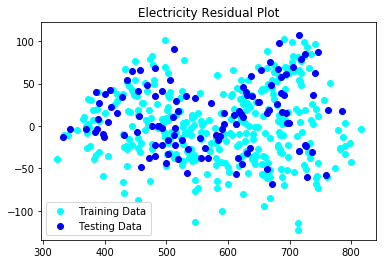

In [116]:
# plot residuals of the predictions
predictions_elc = elc_model.predict(Xelc_test)
elc_model.fit(Xelc_train, yelc_train)
plt.scatter(elc_model.predict(Xelc_train), elc_model.predict(Xelc_train) - yelc_train, c="cyan", label="Training Data")
plt.scatter(elc_model.predict(Xelc_test), elc_model.predict(Xelc_test) - yelc_test, c="blue", label="Testing Data")
plt.legend()
plt.title("Electricity Residual Plot")
plt.savefig('Electricity Residual Plot.jpg')
plt.show()


In [117]:
#show model feature coefficients
elc_model.coef_
elc_coef = pd.concat([pd.DataFrame(X_elc.columns, columns = ['Feature']),pd.DataFrame(np.transpose(elc_model.coef_), columns=['Coef'])], axis = 1)
elc_intercept = elc_model.intercept_

In [118]:
#generate forecast values array and future forecasts array
elc_coefArr=np.array(elc_coef['Coef'])
newX_elc = X_elc.loc[430:454]
newForecasts_elc = []

for j in range(len(newX_elc)):
    j += 430
    newX_elc_row = np.array(newX_elc.loc[j])
    newfcst_elc = newX_elc_row.dot(elc_coefArr)+elc_intercept
    newForecasts_elc.append(newfcst_elc)

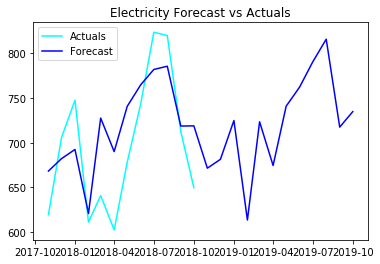

MSE: 1633.231678811085, R2: 0.8766493990950038


In [119]:
#Plot Electricity Forecast
plt.plot(dates,y_elc[442:454], c='cyan', label = "Actuals")
plt.plot(futuredates, newForecasts_elc, c="blue", label="Forecast")
plt.legend()
plt.title("Electricity Forecast vs Actuals")
plt.savefig('Electricity Forecast vs Actuals.jpg')
plt.show()

MSE_elc = mean_squared_error(yelc_test, predictions_elc)
r2_elc = elc_model.score(Xelc_test, yelc_test)

print(f"MSE: {MSE_elc}, R2: {r2_elc}")

In [120]:
#Create dataframe of predicted versus actual values
elc_predicted_df = pd.DataFrame(newForecasts_elc,futuredates, columns =['Predicted Electrical Generation (Billion Kilowatthours)'])
elc_actual_df = pd.DataFrame(y_elc[442:454],dates, columns =['Actual Electrical Generation (Billion Kilowatthours)'])
elc_joineddf = elc_actual_df.join(elc_predicted_df, on='Date', how = 'outer')
elc_df = elc_joineddf.tail(24)
elc_df

#save as csv
elc_df.to_csv('elc.csv')